In [1]:
# Ignore this cell.. Just some standard stuff I do

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1024*6))])
#tf.debugging.set_log_device_placement(True)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Sample code for generating sequences for pose

import random
import numpy as np


ARCHS = ["lstm"]#["lstm", "gru"]
DATAPOINTS = 32*500 #Controls the number of rows of datasets to be generated (For some reason, this needs to be a multiple of 32)
MAX_NUM_FRAMES_PER_POSE = 50 #50 #This is the number of frames that can detect one pose. Like a pose hold of 1 sec can result in 10 frames of one pose
NUM_POSES = 7
REP = [0, 1, 2, 3, 4, 5, 6, 2, 1, 0]
MAX_SEQ_SIZE = 32*100 #Number of columns 
inputs = np.empty([DATAPOINTS, MAX_SEQ_SIZE, NUM_POSES], np.int32) # Format: 3D array: Row index, Column, (0 index for input, 1 index for total number of poses in sequence)
targets = np.empty([DATAPOINTS, MAX_SEQ_SIZE], np.float32) # Format: 2D array: Row index, Column


def checkIfShouldBePartial():
    var = random.randint(0, 9)
    if var < 6: return True
    else: return False

def getFullOrPartialRepLen(repLen, shouldPrint):
    missingIdxs = set()
    if checkIfShouldBePartial():
        return random.randint(2, repLen-1)
    return repLen


def checkIfShouldAddMissing():
    var = random.randint(0, 9)
    if var < 6: return True
    else: return False

def createMissingPoses(repLen, arr, target, shouldPrint):
    missingIdxs = set()
    if checkIfShouldAddMissing():
        missingLen = random.randint(0, repLen-1)
        if shouldPrint: print("missingLen:"+str(missingLen))
        for i in range(missingLen):
            missingIdxs.add(random.randint(2, repLen-1))
    return missingIdxs

def setEmbedding(arr, poseChoice, numPoses, rep):
    for f in range(numPoses):
        arr[f] = 0
    arr[rep[poseChoice]] = 1

def setTargetEmbedding(target, poseChoice, repLen, seqSize, maxSeqSize):
#     for f in range(repLen):
#         target[seqSize][f] = 0
            
#     target[seqSize][poseChoice] = 1
#     if (0 == seqSize): target[seqSize] = 0
    target[seqSize] = (poseChoice+1)/repLen
    

def copyTargetEmbeddingFromLast(target, repLen, seqSize, maxSeqSize):
    if (0 == seqSize): target[seqSize] = 0
    if (seqSize < maxSeqSize):
        target[seqSize] = target[seqSize - 1]
    
        
def generateSeq(numPoses, rep, maxSeqSize, maxFramesPerPose, arr, target, shouldPrint):
    lastTarget = 0
    seqSize = 0
    repLen = len(rep)
    if shouldPrint: print("NumPoses:"+str(numPoses))
    while(seqSize < maxSeqSize):
        if shouldPrint: print("seqSize:"+str(seqSize))
        #Generate some poses that are supposed to be detected wrong
        missingPoses = createMissingPoses(repLen, arr, target, shouldPrint)
        fullOrPartialRepLen = getFullOrPartialRepLen(repLen, shouldPrint)
        for pose in range(fullOrPartialRepLen):
            if shouldPrint: print("Pose:"+str(pose))
            if pose in missingPoses:
                if shouldPrint: print("missingPose:"+str(pose))
                #Pick a wrong pose
                if pose == repLen - 1:
                    poseChoice = random.randint(0, pose-1)
                else:
                    if pose == 0:
                        poseChoice = random.randint(1, repLen-1)
                    else:
                        if random.randint(0, 1) == 0:
                            poseChoice = random.randint(0, pose-1)
                        else:
                            poseChoice = random.randint(pose+1, repLen-1)
                #Adding the pose and output to data

                for time in range(random.randint(1, maxFramesPerPose)):
                    setEmbedding(arr[seqSize], poseChoice, numPoses, rep)
                    copyTargetEmbeddingFromLast(target, repLen, seqSize, maxSeqSize)
                    seqSize = seqSize + 1
                    if (seqSize >= maxSeqSize):
                        break
            else:
                if shouldPrint: print("non-missingPose:"+str(pose))
                for time in range(random.randint(1, maxFramesPerPose)):
                    setEmbedding(arr[seqSize], pose, numPoses, rep)
                    setTargetEmbedding(target, pose, repLen, seqSize, maxSeqSize)
                    seqSize = seqSize + 1
                    if (seqSize >= maxSeqSize):
                        break
                
                if shouldPrint: print("input:"+str(arr[seqSize])+", target:"+str(target[seqSize]))
                #arr[seqSize][1] = numPoses
            
            if (seqSize >= maxSeqSize):
                break


print(inputs.shape)
for i in range(DATAPOINTS):
    generateSeq(NUM_POSES, REP, MAX_SEQ_SIZE, MAX_NUM_FRAMES_PER_POSE, inputs[i], targets[i], False)
print(targets.shape)

(16000, 3200, 7)
(16000, 3200)


In [3]:
print(inputs.shape)
print(targets.shape)
print(targets[0][0])
from numpy import savez_compressed
savez_compressed('inputs.npz', inputs)
savez_compressed('targets.npz', targets)

(16000, 3200, 7)
(16000, 3200)
0.1


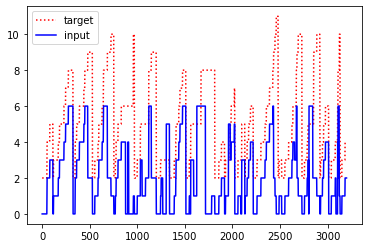

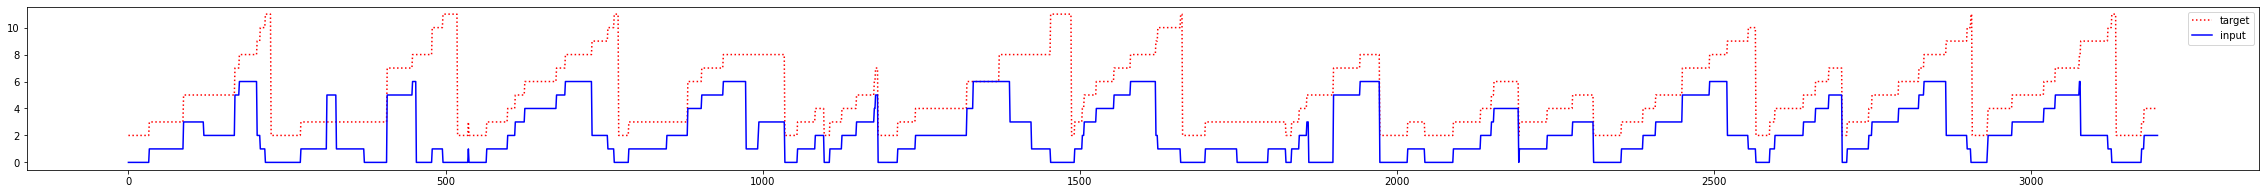

In [4]:
import matplotlib.pyplot as plt

for k in range(2):
    j = random.randint(0, inputs.shape[0]-2)
    plt.plot(targets[j]*10+1, color='r', linestyle='dotted', label="target")
    plt.plot(np.argmax(inputs[j:j+1]+2, axis=2)[0], color='b', label="input")
    plt.rcParams["figure.figsize"] = (40,6)
    plt.legend()
    plt.show()